## Crpytocurrency Price Prediction Analysis

In [65]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [33]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [66]:
btc_data = pd.read_csv(os.getcwd() + '/Data/BTCUSD.csv')
eth_data = pd.read_csv(os.getcwd() + '/Data/ETHUSD.csv')
xrp_data = pd.read_csv(os.getcwd() + '/Data/XRPUSD.csv')

btc_data.rename(columns={'Volume BTC': 'Volume'}, inplace=True)
eth_data.rename(columns={'Volume ETH': 'Volume'}, inplace=True)
xrp_data.rename(columns={'Volume XRP': 'Volume'}, inplace=True)

btc_data = btc_data[btc_data['date'] >= '2017-12-07'].iloc[::-1].reset_index(drop=True)
eth_data = eth_data[eth_data['date'] >= '2017-12-07'].iloc[::-1].reset_index(drop=True)
xrp_data = xrp_data[xrp_data['date'] >= '2017-12-07'].iloc[::-1].reset_index(drop=True)

for df in [btc_data, eth_data, xrp_data]:
    df.drop('unix', axis = 1, inplace = True)
    df['close_MA21'] = df['close'].rolling(window=21).mean().fillna(method='backfill')
    df['close_MA14'] = df['close'].rolling(window=14).mean().fillna(method='backfill')
    df['close_MA10'] = df['close'].rolling(window=21).mean().fillna(method='backfill')
    df['gk_vol'] = np.sqrt(252*((np.log(df['high']/df['low']))**2) - (2*np.log(2) - 1)*((np.log(df['close']/df['open']))**2))
    df['o2c_ret'] = np.log(df['close']/df['open'])

In [68]:
eth_data

,date,symbol,open,high,low,close,Volume,Volume USD,close_MA21,close_MA14,close_MA10,gk_vol,o2c_ret
0,2017-12-07,ETH/USD,462.9989,469.0000,432.151,440.9856,14672.364260,6.470301e+06,717.395614,671.676200,717.395614,1.298622,-0.048712
1,2017-12-08,ETH/USD,440.9846,489.0000,430.000,472.4208,17560.599700,8.295993e+06,717.395614,671.676200,717.395614,2.040652,0.068860
2,2017-12-09,ETH/USD,470.2031,520.0000,443.000,492.9990,17717.342200,8.734632e+06,717.395614,671.676200,717.395614,2.543863,0.047342
3,2017-12-10,ETH/USD,491.8230,492.9972,451.000,457.9000,12019.368470,5.503669e+06,717.395614,671.676200,717.395614,1.412707,-0.071468
4,2017-12-11,ETH/USD,458.4595,529.0000,458.170,526.9999,10348.019790,5.453405e+06,717.395614,671.676200,717.395614,2.280287,0.139328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,2023-06-05,ETH/USD,1890.3700,1890.3700,1801.220,1816.6000,146.545212,2.662140e+05,1848.534286,1863.578571,1848.534286,0.766472,-0.039806
2007,2023-06-06,ETH/USD,1816.3100,1894.8000,1805.370,1882.6000,187.980309,3.538917e+05,1851.026190,1865.528571,1851.026190,0.767173,0.035847
2008,2023-06-07,ETH/USD,1882.6600,1896.1400,1831.070,1833.9000,93.950644,1.722961e+05,1851.405714,1867.696429,1851.405714,0.554094,-0.026241
2009,2023-06-08,ETH/USD,1834.2700,1859.6000,1834.270,1849.3400,32.602683,6.029345e+04,1853.421429,1870.412857,1853.421429,0.217657,0.008182


In [35]:
scaler = MinMaxScaler(feature_range=(-1,1)) # scale time-series between -1 and 1
btc_data['norm_close'] = scaler.fit_transform(btc_data['close'].values.reshape(-1,1))

In [36]:
# LSTM 
import torch
import torch.nn as nn

# Load data for each crypto
def load_data(crypto, look_back):
    data_raw = crypto[['norm_close']].to_numpy()
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
        
    data = np.array(data) # makes it 2d

    # Split into test-train sets
    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0] - test_size
    

    x_train = data[:train_size,:-1,:] # splitting is done here
    y_train = data[:train_size,-1,:]

    x_test = data[train_size:,:-1]
    y_test = data[train_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

# LSTM Implementation
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully-connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out


# GRU Implementation
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [54]:
lookback = 60
x_train, y_train, x_test, y_test = load_data(btc_data, lookback)

# Convert data into tensors for Pytorch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


# Parameters, we can tune this later
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 3
learning_rate = 0.01

# Initialize model, loss function and optimizer
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim,  num_layers=num_layers, output_dim=output_dim)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [55]:
x_train.shape, y_train.shape

(torch.Size([1561, 59, 1]), torch.Size([1561, 1]))

In [56]:
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

In [57]:
# Train Model
num_epochs = 50
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    
    # Forward pass
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    
    if t % 10 == 0 and t !=0:
        print("Epoch", t, "MSE: ", np.around(loss.item(), 5))

    hist[t] = loss.item() # Store results

    # Optimize, and zero out gradient
    optimizer.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    optimizer.step()

training_time = time.time()-start_time
print("Training time: {} seconds".format(np.around(training_time,2)))

Epoch 10 MSE:  0.00735
Epoch 20 MSE:  0.01236
Epoch 30 MSE:  0.0055
Epoch 40 MSE:  0.00271
Training time: 25.1 seconds


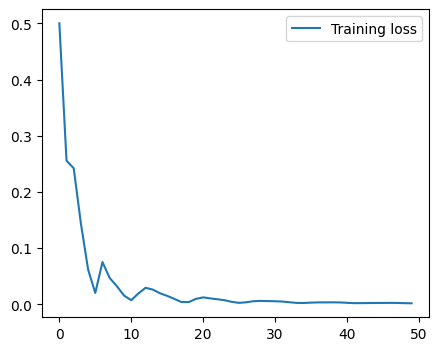

In [58]:
fig = plt.figure(figsize=(5,4))
plt.plot(hist, label="Training loss")
plt.legend()

In [59]:
# Make Predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1391.90 RMSE
Test Score: 1519.56 RMSE


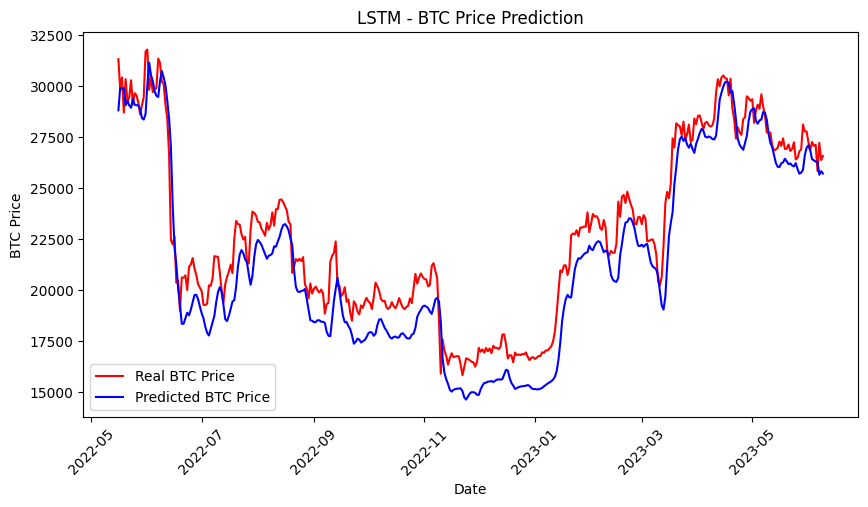

In [60]:
# Visualising the results
figure, axes = plt.subplots(figsize=(10, 5))

axes.plot(pd.to_datetime(btc_data[len(btc_data)-len(y_test):]['date']), y_test, color = 'red', label = 'Real BTC Price')
axes.plot(pd.to_datetime(btc_data[len(btc_data)-len(y_test):]['date']), y_test_pred, color = 'blue', label = 'Predicted BTC Price')
#axes.xticks(np.arange(0,394,50))
plt.title('LSTM - BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.xticks(rotation=45)
plt.legend()


In [232]:
#stationarity, seasonality and (partial) autocorrelation
#for p,q 
#ARMA model
# >>req strict stationarity and "AIC", so d=0. if non-stationary find d. 
# on closed data
#https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/
#https://builtin.com/data-science/time-series-forecasting-python

In [233]:
#test for stationarity - augmented dicky fuller test

result = adfuller(btc_data['close'])
print('ADF Stat: %f' %result[0])
print('p-value: %f' % result[1])
print('critical values')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key,value))
#non-stationary,, p > 0.05

ADF Stat: -1.401854
p-value: 0.581387
critical values
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [234]:
#test for stationarity - KPSS test

print(kpss(btc_data['close'],regression = 'c'))
#non-stationary,, p < 0.05

#ADF and KPSS agree, series is non-stationary. must do both differencing and detrending.

(3.480387404956096, 0.01, 28, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\Shahriyar\AppData\Local\Temp\ipykernel_8464\386941711.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  print(kpss(btc_data['close'],regression = 'c'))


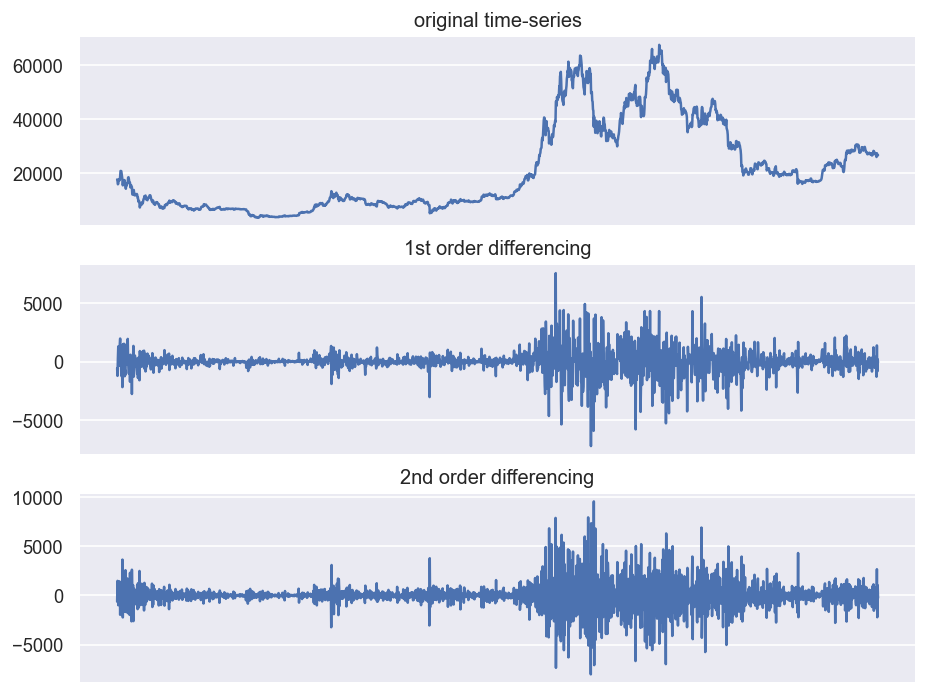

In [235]:
#non-stationary: seek d-value for ARMA
#
close_data = btc_data['close']
plt.rcParams.update({'figure.figsize':(9,7),'figure.dpi':120})

fig, (ax1,ax2,ax3) = plt.subplots(3)
ax1.plot(close_data);
ax1.set_title('original time-series')
ax1.axes.xaxis.set_visible(False)
ax2.plot(close_data.diff());
ax2.set_title('1st order differencing')
ax2.axes.xaxis.set_visible(False)
ax3.plot(close_data.diff().diff());
ax3.set_title('2nd order differencing')
ax3.axes.xaxis.set_visible(False)
plt.show()

#choose first order differencing as second order has increased noise.
#d=1

In [236]:
#doing  first diff and log transform for more stationary 
#close_data_log = close_data.diff();
#close_data = np.log(close_data)
#fig, (ax1,ax2,ax3) = plt.subplots(3)
#ax1.plot(close_data);
#ax1.set_title('log time-series')
#ax1.axes.xaxis.set_visible(False)
#ax2.plot(close_data.diff());
#ax2.set_title('1st diff on log of series')
#ax2.axes.xaxis.set_visible(False)
#ax3.plot(close_data.diff().diff())
#ax3.set_title('2nd diff on log of series')
#ax3.axes.xaxis.set_visible(False)
plt.show()

#we can once again see increased noise in 2nd diff of the log transformed time series. 1st order good.

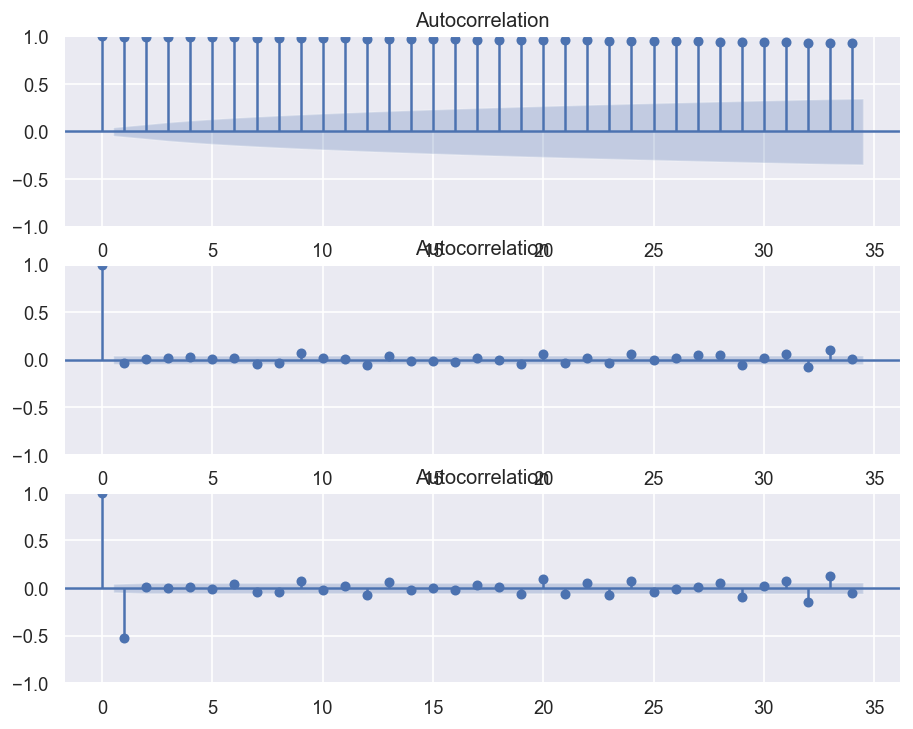

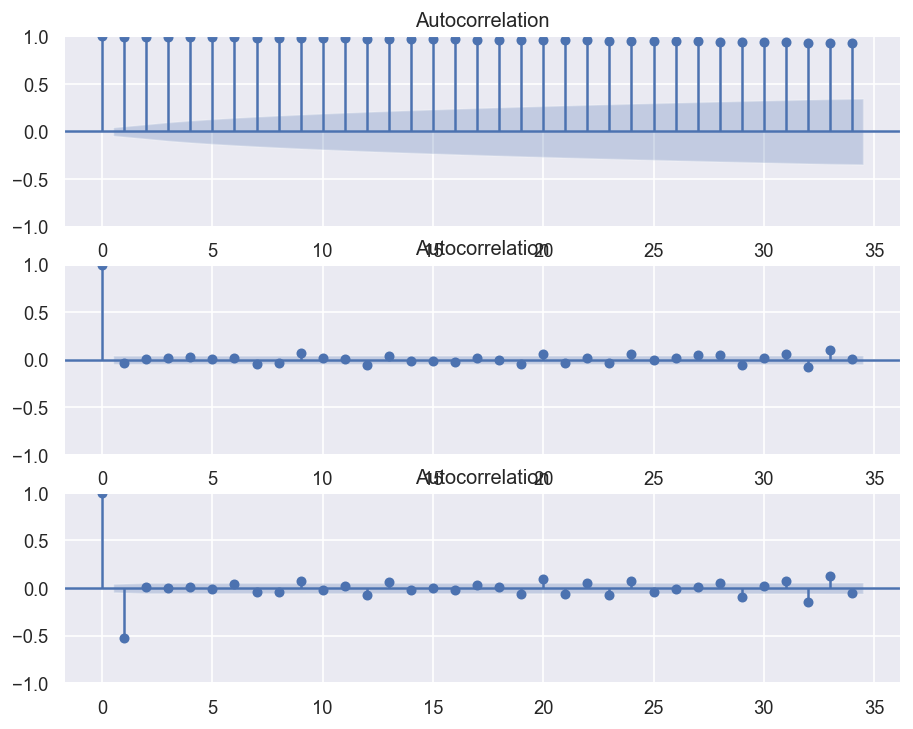

In [237]:
#verify d value w/ autocorrelation plot
fig, (ax1,ax2,ax3) = plt.subplots(3)
plot_acf(close_data, ax=ax1)
plot_acf(close_data.diff().dropna(),ax=ax2)
plot_acf(close_data.diff().diff().dropna(),ax=ax3)
#once again, we see the second lag goes to negative side, and that the series has gone over difference.
# select d=1 yes. 


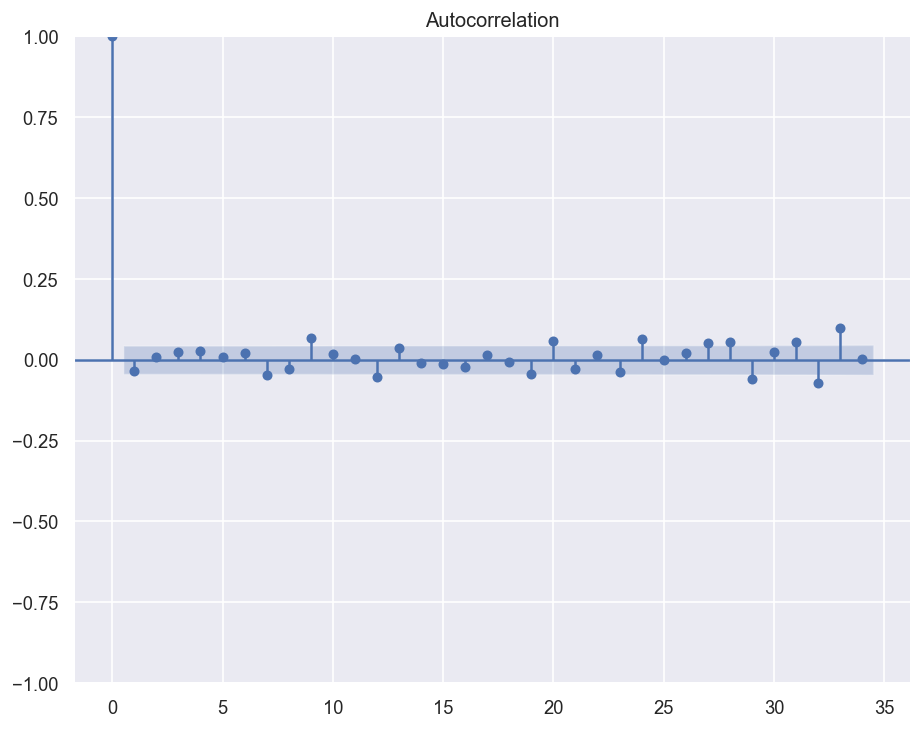

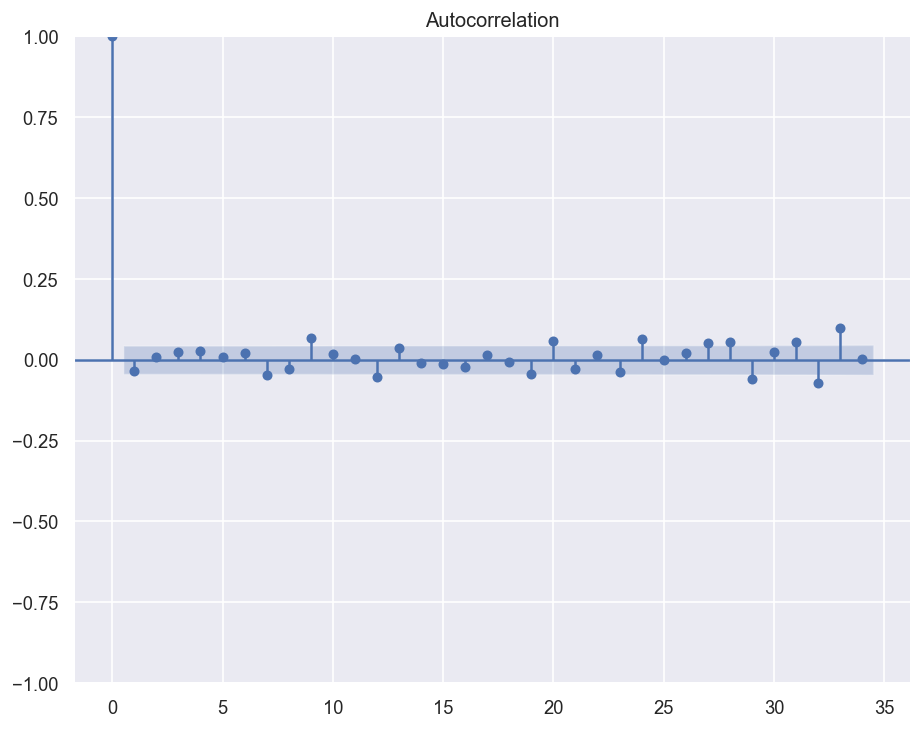

In [238]:
#find q value w/ACF 

plot_acf(close_data.diff().dropna())

#there is 1 lag out of significance limit range, so our optimal q value is MA(1)



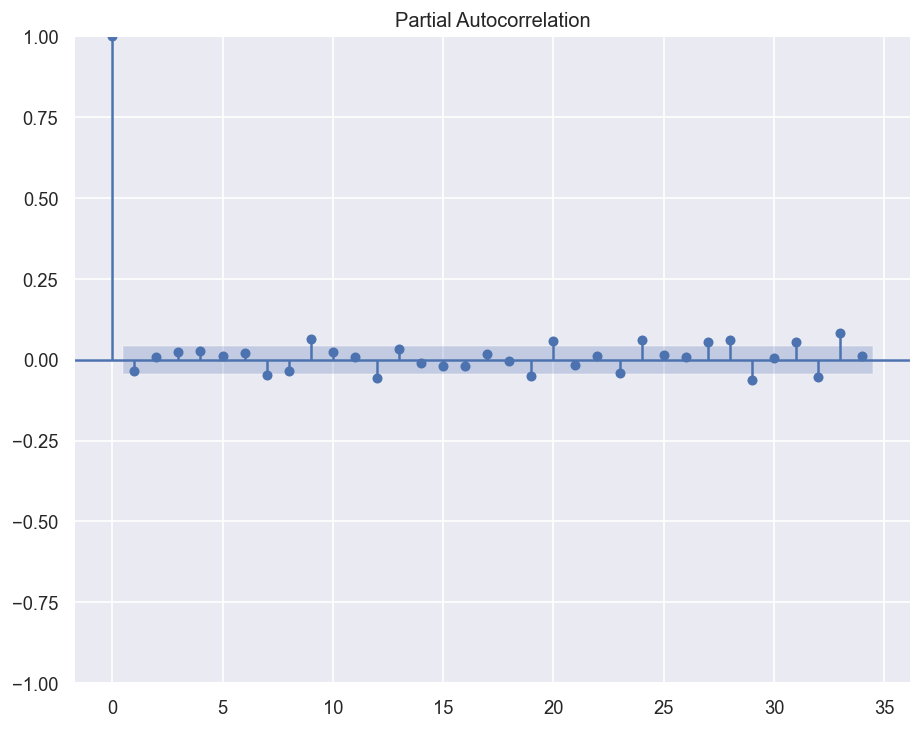

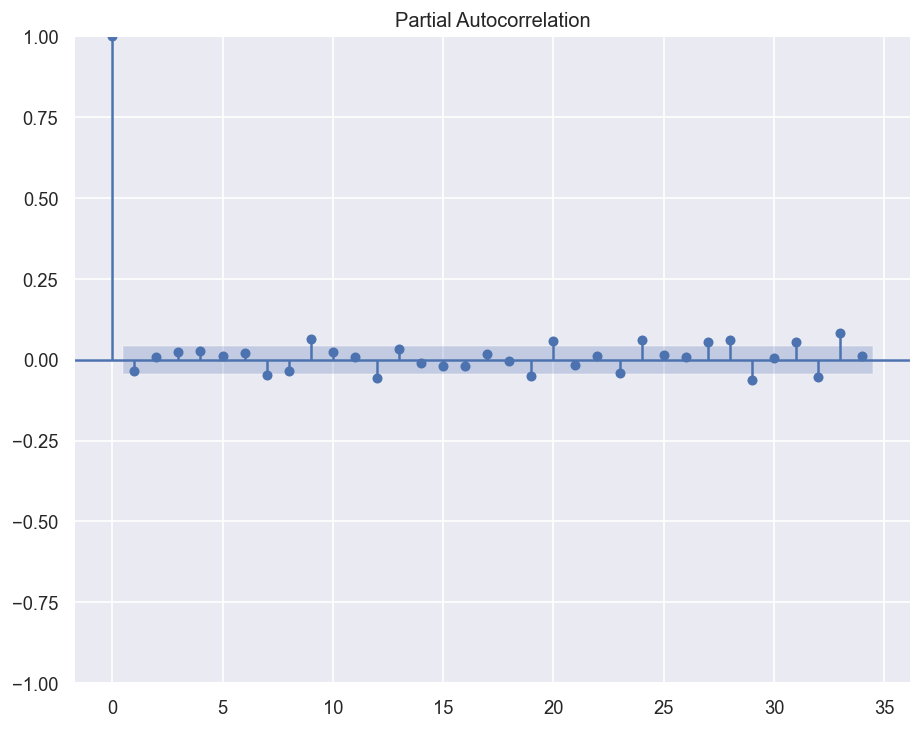

In [239]:
#find p value w/PACF

plot_pacf(close_data.diff().dropna())

#the first lag is significantly out of the limit, so we select p = AR(1)

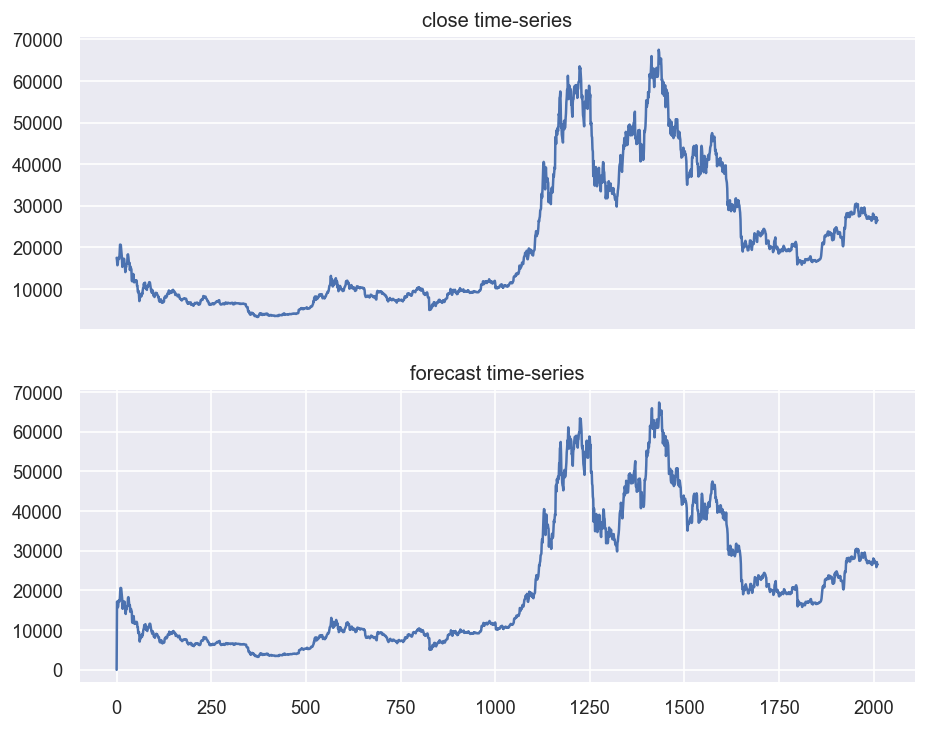

In [264]:
#building ARIMA model
# d = 1 , p = 1 , q = 1, order(p,d,q)

model = ARIMA(close_data, order = (1,1,1))
model_fit = model.fit()
model_fit.summary()

model_predict = model_fit.predict(dynamic=False)

fig, (ax1,ax2) = plt.subplots(2)
ax1.plot(close_data);
ax1.set_title('close time-series')
ax1.axes.xaxis.set_visible(False)

ax2.plot(model_predict);
ax2.set_title('forecast time-series')
ax3.axes.xaxis.set_visible(False)

#note need to pass close_data w/ time?
#missing split data into train/test section

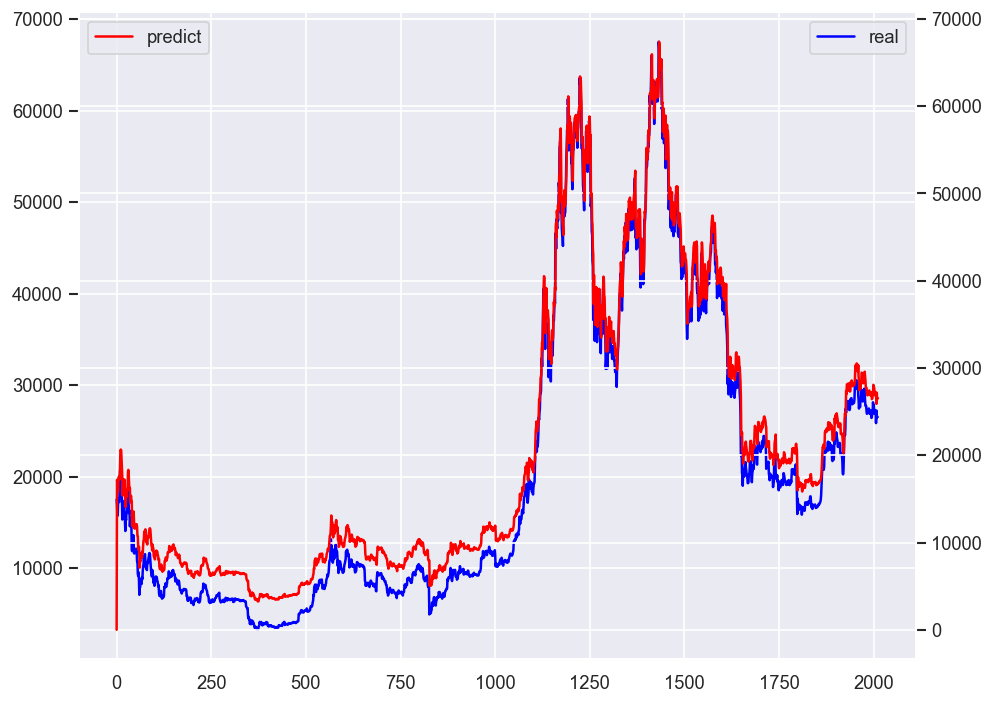

In [262]:
#comparing prediction to original time series
ax1 = close_data.plot(color='blue', grid=True, label='real')
ax2 = model_predict.plot(color='red', grid=True, secondary_y=True, label='predict')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

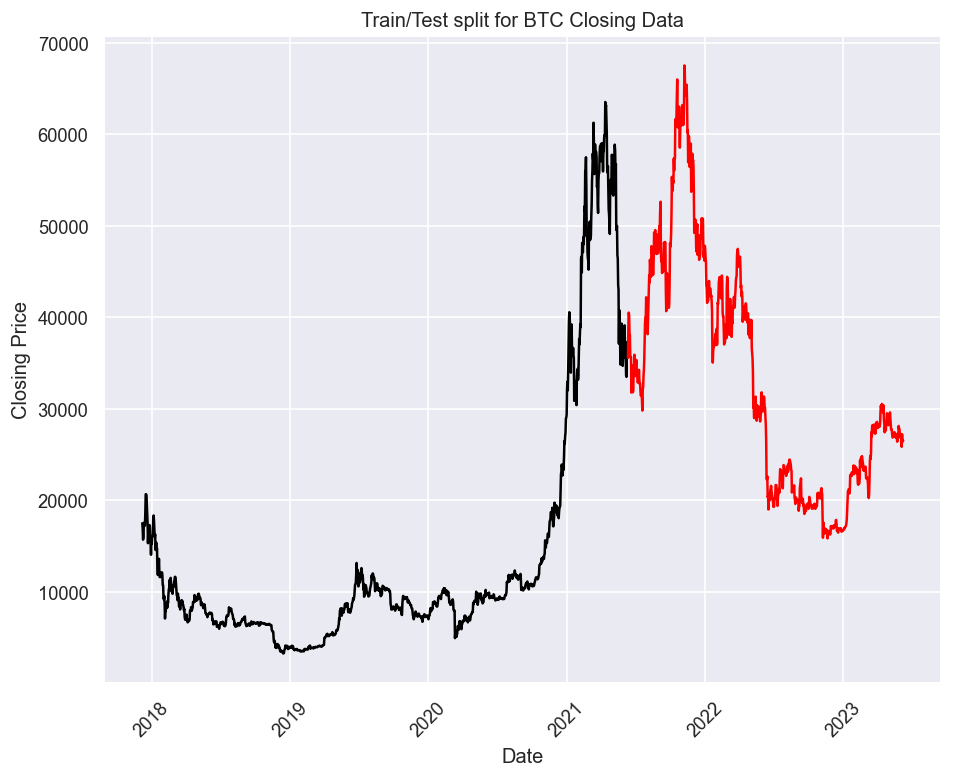

In [263]:
#split data for training and testing
closing_data = btc_data[['date','close']]
closing_data.index = pd.to_datetime(btc_data['date'], format='%Y-%m-%d')
del closing_data['date']
closing_data

#let's say everything before 2021-06-11 is training data, and everything after is testing
train = closing_data[closing_data.index < pd.to_datetime("2021-06-11", format='%Y-%m-%d')]
test = closing_data[closing_data.index > pd.to_datetime("2021-06-11", format='%Y-%m-%d')]

#idk what this is, but its something
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Closing Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Closing Data")
plt.show()

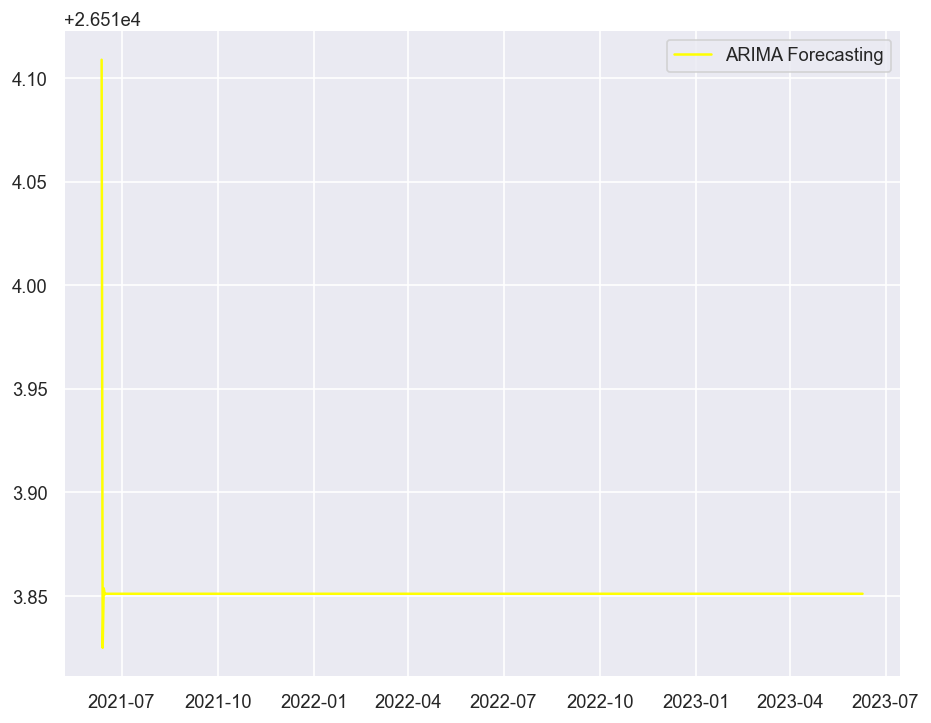

In [277]:
#defining ARIMA forecasting

cd_pred = model_fit.get_forecast(len(test.index))
cd_pred_df = cd_pred.conf_int(alpha = 0.05)
cd_pred_df["Predictions"] = model_fit.predict(start = cd_pred_df.index[0], end = cd_pred_df.index[-1])

cd_pred_df.index = test.index
cd_pred_out = cd_pred_df["Predictions"]

plt.plot(cd_pred_out, color = 'Yellow', label = 'ARIMA Forecasting' )
plt.legend()

arma_rmse = np.sqrt(mean_squared_error(test["close"].values, cd_pred_df["Predictions"]))

plt.show()

#???